# Курс Глубокое обучение в компьютерном зрении

# Задание урока 8. Синтез изображений. Часть 2. Генеративно-Состязательная Сеть (GAN)
Реализовать синтезирование лиц из LFW с помощью DCGAN
* Библиотеки: [Python, Tensorflow]


## Установка библиотек и скриптов

In [1]:
# Переключение версии TensorFlow
%tensorflow_version 2.x

In [2]:
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
import tensorflow_datasets as tfds

## Загрузка датасета LFW

In [3]:
train_ds, ds_info = tfds.load(
    'lfw',
    as_supervised=True,
    with_info=True,
    split='train',)

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

0 examples [00:00, ? examples/s]

Shuffling and writing examples to /root/tensorflow_datasets/lfw/0.1.0.incompleteE3POUU/lfw-train.tfrecord


  0%|          | 0/13233 [00:00<?, ? examples/s]

Dataset lfw downloaded and prepared to /root/tensorflow_datasets/lfw/0.1.0. Subsequent calls will reuse this data.


In [4]:
tfds.builder('lfw').info

tfds.core.DatasetInfo(
    name='lfw',
    version=0.1.0,
    description='Labeled Faces in the Wild:
        A Database for Studying Face Recognition in
        Unconstrained Environments',
    homepage='http://vis-www.cs.umass.edu/lfw',
    features=FeaturesDict({
        'image': Image(shape=(250, 250, 3), dtype=tf.uint8),
        'label': Text(shape=(), dtype=tf.string),
    }),
    total_num_examples=13233,
    splits={
        'train': 13233,
    },
    supervised_keys=('label', 'image'),
    citation="""@TechReport{LFWTech,
        author = {Gary B. Huang and Manu Ramesh and Tamara Berg and Erik Learned-Miller},
        title = {Labeled Faces in the Wild: A Database for Studying Face Recognition in Unconstrained Environments},
        institution = {University of Massachusetts, Amherst},
        year = 2007,
        number = {07-49},
        month = {October}
    }""",
    redistribution_info=,
)

## Визуализация датасета LFW

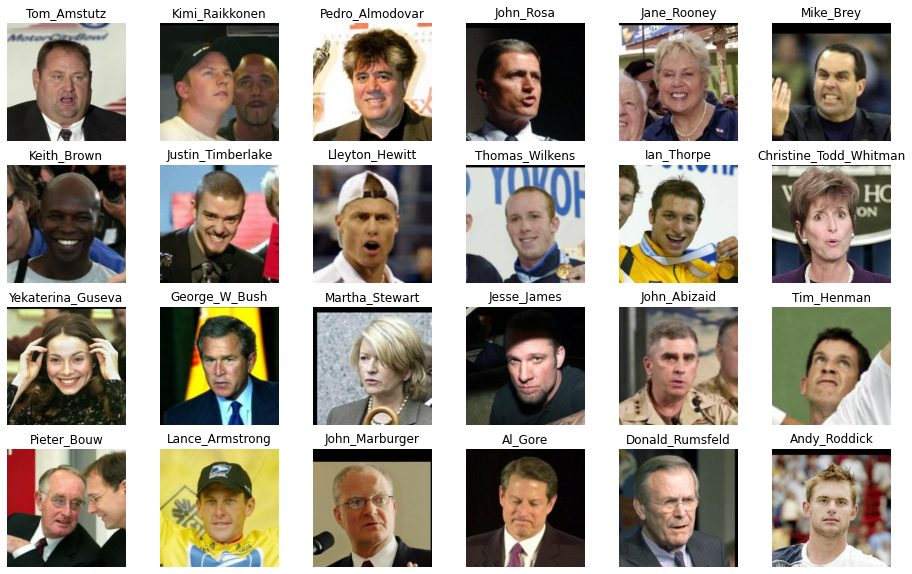

In [6]:
plt.figure(figsize=(16, 10))
for j, x in enumerate(train_ds.take(24)):
    plt.subplot(4, 6, j+1)
    plt.title(x[0].numpy().decode('utf-8'))  # x[0] - метка класса
    plt.imshow(x[1])  # x[1] - изображение
    plt.axis('off')

In [7]:
# Функция вывода картинок во время обучения
def plot_faces(samples):
    fig = plt.figure(figsize=(10, 10))
    num = samples.shape[0]
    for j in range(num):
        ax = fig.add_subplot(8, 8, j+1)
        new_img = (samples[j, ...] * 127.5) + 127.5
        new_img = (tf.cast(new_img, tf.int16))
        ax.imshow(new_img)
        plt.xticks([]), plt.yticks([])
    plt.show()

## Создание модели Deep Convolutional GAN (DCGAN)

In [8]:
generator = tf.keras.Sequential([
    tf.keras.layers.Dense(256*7*7),
    tf.keras.layers.LeakyReLU(),
    tf.keras.layers.Reshape((7, 7, 256)),

    tf.keras.layers.UpSampling2D((2, 2)),    
    tf.keras.layers.Conv2D(256, (3, 3), padding='same'),
    tf.keras.layers.BatchNormalization(momentum=0.8),
    tf.keras.layers.LeakyReLU(),

    tf.keras.layers.UpSampling2D((2, 2)),    
    tf.keras.layers.Conv2D(128, (3, 3), padding='same'),
    tf.keras.layers.BatchNormalization(momentum=0.8),
    tf.keras.layers.LeakyReLU(),

    tf.keras.layers.UpSampling2D((2, 2)),    
    tf.keras.layers.Conv2D(64, (3, 3), padding='same'),
    tf.keras.layers.BatchNormalization(momentum=0.8),
    tf.keras.layers.LeakyReLU(),

    tf.keras.layers.UpSampling2D((2, 2)),    
    tf.keras.layers.Conv2D(32, (3, 3), padding='same'),
    tf.keras.layers.BatchNormalization(momentum=0.8),
    tf.keras.layers.LeakyReLU(),

    tf.keras.layers.UpSampling2D((2, 2)),    
    tf.keras.layers.Conv2D(16, (3, 3), padding='same'),
    tf.keras.layers.BatchNormalization(momentum=0.8),
    tf.keras.layers.LeakyReLU(),

    tf.keras.layers.Conv2D(3, (3, 3), padding='same', activation='tanh'),  # функция tanh от -1 до 1
])

discriminator = tf.keras.Sequential([
    tf.keras.layers.Conv2D(32, (3, 3), strides=(2, 2), padding='same'),
    tf.keras.layers.LeakyReLU(0.2),
    tf.keras.layers.Dropout(0.25),

    tf.keras.layers.Conv2D(64, kernel_size=3, strides=(2, 2), padding='same'),
    tf.keras.layers.ZeroPadding2D(padding=((0, 1), (0, 1))),
    tf.keras.layers.BatchNormalization(momentum=0.8),
    tf.keras.layers.LeakyReLU(alpha=0.2),
    tf.keras.layers.Dropout(0.25),

    tf.keras.layers.Conv2D(128, kernel_size=3, strides=(2, 2), padding='same'),
    tf.keras.layers.BatchNormalization(momentum=0.8),
    tf.keras.layers.LeakyReLU(alpha=0.2),
    tf.keras.layers.Dropout(0.25),

    tf.keras.layers.Conv2D(256, kernel_size=3, strides=(1, 1), padding='same'),
    tf.keras.layers.BatchNormalization(momentum=0.8),
    tf.keras.layers.LeakyReLU(alpha=0.2),
    tf.keras.layers.Dropout(0.25),

    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(1),  # характеризует, к какому классу относится картинка: 0 - фейк, 1- истина
])

## Подготовка пайплайна данных и оптимизатора

In [9]:
NUM_EPOCHS = 20
HALF_BATCH_SIZE = 16  # размер серии генерируемых картинок

def prepare_img(label, img):
    img = tf.image.resize(img, [224, 224]) # корректировка размерности входа в модель
    return label, (tf.cast(img, tf.float32) - 127.5) / 127.5  # стандартизация картинок от -1 до 1

train_ds = train_ds.repeat(NUM_EPOCHS)
train_ds = train_ds.batch(HALF_BATCH_SIZE, drop_remainder=True)
train_ds = train_ds.map(prepare_img)

In [10]:
INPUT_DIM = 200
BATCH_SIZE = HALF_BATCH_SIZE * 2  # вторая половина батча - истинные картинки
LEARNING_RATE = 0.0002

optimizer = tf.keras.optimizers.Adam(LEARNING_RATE)
sigmoid_cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

## Обучение DCGAN

[Step  0] D Loss: 0.7177; G Loss: 0.5337


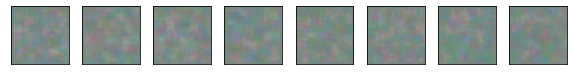

[Step 1000] D Loss: 1.7048; G Loss: 21.8859


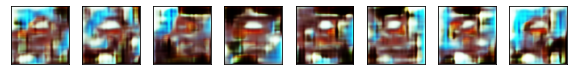

[Step 2000] D Loss: 1.9239; G Loss: 14.6169


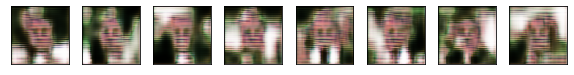

[Step 3000] D Loss: 0.2380; G Loss: 64.6887


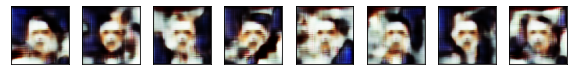

[Step 4000] D Loss: 0.0120; G Loss: 25.5926


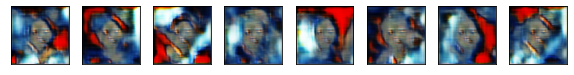

[Step 5000] D Loss: 0.6221; G Loss: 36.0882


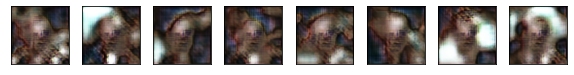

[Step 6000] D Loss: 1.1671; G Loss: 37.4853


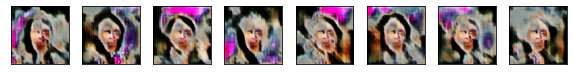

[Step 7000] D Loss: 0.4634; G Loss: 9.3070


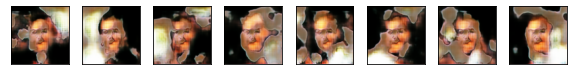

[Step 8000] D Loss: 0.0122; G Loss: 15.5427


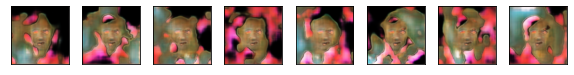

[Step 9000] D Loss: 0.8919; G Loss: 9.3722


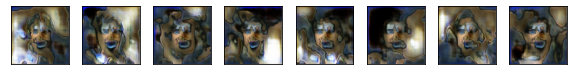

[Step 10000] D Loss: 0.1126; G Loss: 7.6924


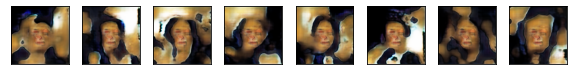

[Step 11000] D Loss: 0.0418; G Loss: 11.1133


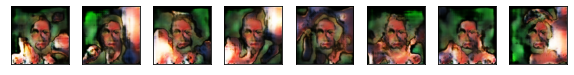

[Step 12000] D Loss: 0.4912; G Loss: 9.6486


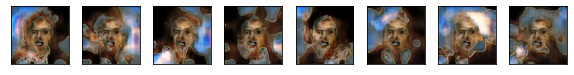

[Step 13000] D Loss: 0.0162; G Loss: 9.6498


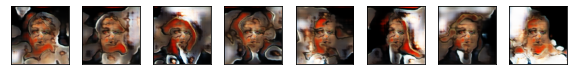

[Step 14000] D Loss: 0.4696; G Loss: 5.8400


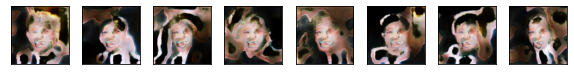

[Step 15000] D Loss: 0.2457; G Loss: 5.0815


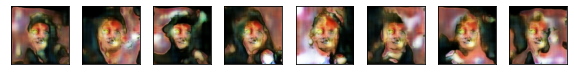

[Step 16000] D Loss: 0.1329; G Loss: 4.4088


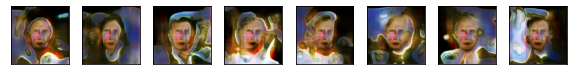

In [11]:
for step, (_, true_images) in enumerate(train_ds):
    
    # Train Discriminator (шаг обучения генератора)
    
    noise = np.random.normal(0, 1, (HALF_BATCH_SIZE, INPUT_DIM)).astype(np.float32)
    syntetic_images = generator.predict(noise)  # получаем батч синтетических картинок
    x_combined = np.concatenate((
        true_images, 
        syntetic_images))
    y_combined = np.concatenate((
        np.ones((HALF_BATCH_SIZE, 1), np.float32),   # единицы соответствуют истинным картинкам
        np.zeros((HALF_BATCH_SIZE, 1), np.float32)))  # нули соответствуют синтетическим картинкам
    
    with tf.GradientTape() as tape:
        logits = discriminator(x_combined, training=True)
        d_loss_value = sigmoid_cross_entropy(y_combined, logits)
    grads = tape.gradient(d_loss_value, discriminator.trainable_variables)
    optimizer.apply_gradients(zip(grads, discriminator.trainable_variables))
    
    # Train Generator (шаг обучения генератора)
    
    noise = np.random.normal(0, 1, (BATCH_SIZE, INPUT_DIM)).astype(np.float32)  # генерируем батч случайных векторов
    y_mislabled = np.ones((BATCH_SIZE, 1), np.float32)  # сощдаем метки 1 для дискриминатора
    
    with tf.GradientTape() as tape:
        syntetic = generator(noise, training=True)  # при training=True BatchNormalization работает в режиме обучения
        logits = discriminator(syntetic, training=False)
        g_loss_value = sigmoid_cross_entropy(y_mislabled, logits)
    grads = tape.gradient(g_loss_value, generator.trainable_variables)
    optimizer.apply_gradients(zip(grads, generator.trainable_variables))
    
    # Check intermediate results
    
    if step % 1000 == 0:
        print('[Step %2d] D Loss: %.4f; G Loss: %.4f' % (
            step, d_loss_value.numpy(), g_loss_value.numpy()))
        noise = np.random.normal(0, 1, (8, INPUT_DIM)).astype(np.float32)
        syntetic_images = generator.predict(noise)
        plot_faces(syntetic_images)

## Тестирование генератора

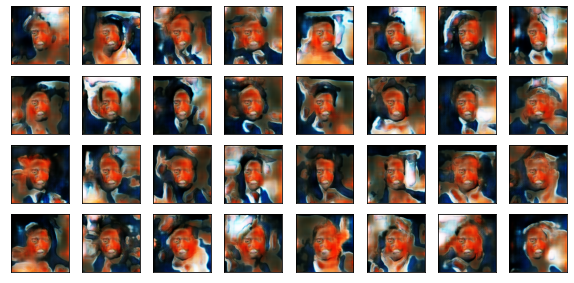

In [13]:
noise = np.random.normal(0, 1, (32, INPUT_DIM)).astype(np.float32)  # возьмем 32 вектора
syntetic_images = generator.predict(noise)
plot_faces(syntetic_images)

## Интерполяция в латентном пространстве

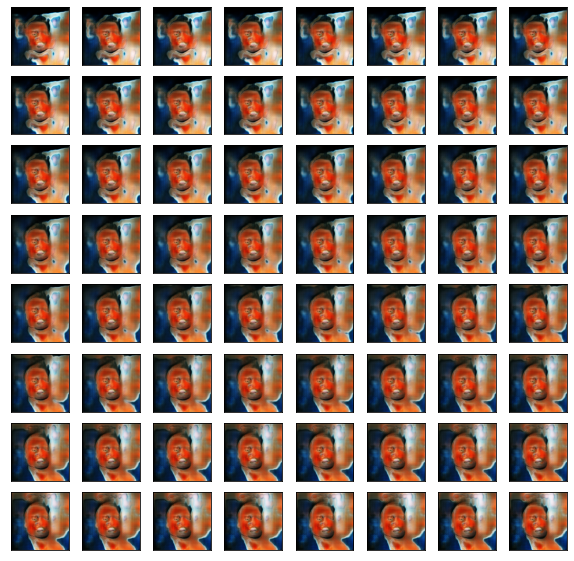

In [14]:
# переход от одного изображений к другому
noise_1 = np.random.normal(0, 1, (INPUT_DIM)).astype(np.float32)
noise_2 = np.random.normal(0, 1, (INPUT_DIM)).astype(np.float32)
noise = np.linspace(noise_1, noise_2, 64)
syntetic_images = generator.predict(noise)
plot_faces(syntetic_images)